### Training RNN using World's data

This is based on `COVID-19 growth prediction using multivariate
long short term memory` by `Novanto Yudistira`

https://arxiv.org/pdf/2005.04809.pdf

https://github.com/VICS-CORE/lstmcorona/blob/master/lstm.py

In [36]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import torch

tnn = torch.nn
top = torch.optim
from torch.utils import data as tdt

In [18]:
!head -n1 csv/owid-covid-data.csv

iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k


In [19]:
cols = ['location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'population']
dates = ['date']
df = pd.read_csv("csv/owid-covid-data.csv", 
                 usecols=cols,
                 parse_dates=dates)
df.sample()

,location,date,total_cases,new_cases,total_deaths,new_deaths,population
6155,United Kingdom,2020-02-15,9,0,0,0,67886004.0


### Prepare dataset

In [49]:
IP_SEQ_LEN = 20
OP_SEQ_LEN = 10
VAL_SPLIT = 0.3

ip_train = []
op_train = []

countries = df['location'].unique()
c = 0
for country in countries:
    if country in ['World', 'International']: 
        continue
    country_df = df.loc[df.location == country]
    tot_cases_gt_100 = (country_df['total_cases'] >= 100)
    country_df = country_df.loc[tot_cases_gt_100]
    
    if len(country_df) >= IP_SEQ_LEN + OP_SEQ_LEN:
        c += 1
        pop = country_df['population'].iloc[0]
        print(c, country, len(country_df), pop)
        daily_cases = np.array(country_df['new_cases'].rolling(7, center=True, min_periods=1).mean() * 1000 / pop, dtype=np.float32)
        for i in range(len(country_df) - IP_SEQ_LEN - OP_SEQ_LEN + 1):
            ip_train.append(daily_cases[i : i+IP_SEQ_LEN])
            op_train.append(daily_cases[i+IP_SEQ_LEN : i+IP_SEQ_LEN+OP_SEQ_LEN])

ip_train = torch.from_numpy(np.array(ip_train, dtype=np.float32))
op_train = torch.from_numpy(np.array(op_train, dtype=np.float32))
dataset = tdt.TensorDataset(ip_train, op_train)

val_len = int(VAL_SPLIT * len(dataset))
trn_len = len(dataset) - val_len
trn_set, val_set = tdt.random_split(dataset, (trn_len, val_len))
print("Training data:", trn_len, "Validation data:", val_len)

trn_loader = tdt.DataLoader(trn_set, shuffle=True, batch_size=1)
val_loader = tdt.DataLoader(val_set, shuffle=True, batch_size=1)
all_loader = tdt.DataLoader(dataset, shuffle=False, batch_size=1)

1 Afghanistan 52 38928341.0
2 Albania 57 2877800.0
3 Andorra 58 77265.0
4 United Arab Emirates 63 9890400.0
5 Argentina 61 45195777.0
6 Armenia 62 2963234.0
7 Australia 71 25499881.0
8 Austria 72 9006400.0
9 Azerbaijan 54 10139175.0
10 Belgium 74 11589616.0
11 Burkina Faso 55 20903278.0
12 Bangladesh 43 164689383.0
13 Bulgaria 61 6948445.0
14 Bahrain 71 1701583.0
15 Bosnia and Herzegovina 58 3280815.0
16 Belarus 50 9449321.0
17 Bolivia 50 11673029.0
18 Brazil 66 212559409.0
19 Brunei 56 437483.0
20 Canada 69 37742157.0
21 Switzerland 74 8654618.0
22 Chile 64 19116209.0
23 China 122 1439323774.0
24 Cote d'Ivoire 53 26378275.0
25 Cameroon 50 26545864.0
26 Democratic Republic of Congo 48 89561404.0
27 Congo 34 5518092.0
28 Colombia 62 50882884.0
29 Costa Rica 60 5094114.0
30 Cuba 52 11326616.0
31 Cyprus 57 875899.0
32 Czech Republic 68 10708982.0
33 Germany 80 83783945.0
34 Djibouti 42 988002.0
35 Denmark 71 5792203.0
36 Dominican Republic 59 10847904.0
37 Algeria 60 43851043.0
38 Ecuador

### LSTM

In [41]:
class YudistirNet(tnn.Module):
    def __init__(self, ip_seq_len=1, op_seq_len=1, hidden_size=1, num_layers=1):
        super(YudistirNet, self).__init__()
        
        self.ip_seq_len = ip_seq_len
        self.op_seq_len = op_seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = tnn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
        self.linear = tnn.Linear(self.hidden_size * self.ip_seq_len, self.op_seq_len)
        self.sigmoid = tnn.Sigmoid()
    
    def forward(self, ip):
        lstm_out, _ = self.lstm(ip)
        linear_out = self.linear(lstm_out.view(self.hidden_size * self.ip_seq_len))
        sigmoid_out = self.sigmoid(linear_out.view(self.op_seq_len))
        return sigmoid_out
    
    def predict(self, ip):
        with torch.no_grad():
            preds = self.forward(ip)
        return preds

### Train

epoch:   0 avg_val_loss:  0.00097 avg_trn_loss:  0.00256
epoch:   1 avg_val_loss:  0.00050 avg_trn_loss:  0.00075
epoch:   2 avg_val_loss:  0.00049 avg_trn_loss:  0.00058
epoch:   3 avg_val_loss:  0.00048 avg_trn_loss:  0.00046
epoch:   4 avg_val_loss:  0.00042 avg_trn_loss:  0.00043
epoch:   5 avg_val_loss:  0.00039 avg_trn_loss:  0.00038
epoch:   6 avg_val_loss:  0.00037 avg_trn_loss:  0.00035
epoch:   7 avg_val_loss:  0.00032 avg_trn_loss:  0.00033
epoch:   8 avg_val_loss:  0.00033 avg_trn_loss:  0.00033
epoch:   9 avg_val_loss:  0.00030 avg_trn_loss:  0.00030


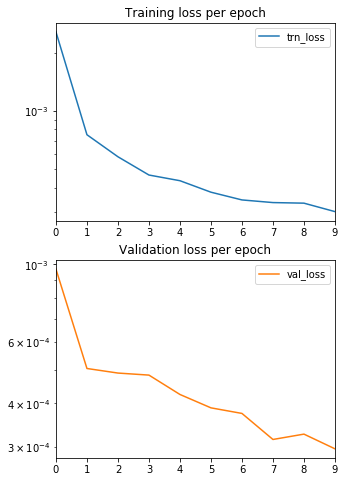

In [50]:
HIDDEN_SIZE = 1
NUM_LAYERS = 1
LEARNING_RATE = 0.01
NUM_EPOCHS = 10

model = YudistirNet(ip_seq_len=IP_SEQ_LEN, op_seq_len=OP_SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=LEARNING_RATE)

# TRAIN
trn_loss_vals = []
val_loss_vals = []

for e in range(NUM_EPOCHS):
    model.train()
    trn_losses = []
    for i, data in enumerate(trn_loader):
        ip, op = data        
        optimizer.zero_grad() # set grads to 0
        preds = model(ip.view(IP_SEQ_LEN, 1, 1)) # predict
        loss = loss_fn(preds, op.view(OP_SEQ_LEN)) # calc loss
        loss.backward() # calc and assign grads
        optimizer.step() # update weights
        trn_losses.append(loss) # logging
    avg_trn_loss = torch.stack(trn_losses).mean().item()
    trn_loss_vals.append(avg_trn_loss)
    
    model.eval()
    with torch.no_grad():
        val_losses = []
        for i, data in enumerate(val_loader):
            ip, op = data
            preds = model(ip.view(IP_SEQ_LEN, 1, 1))
            loss = loss_fn(preds, op.view(OP_SEQ_LEN))
            val_losses.append(loss)
        avg_val_loss = torch.stack(val_losses).mean().item()
        val_loss_vals.append(avg_val_loss)
    
    if e%1==0:
        print("epoch:", f"{e:3}", "avg_val_loss:", f"{avg_val_loss: .5f}", "avg_trn_loss:", f"{avg_trn_loss: .5f}")

df_trn_loss = pd.DataFrame({
    'trn_loss': trn_loss_vals,
    'val_loss': val_loss_vals
})
_ = df_trn_loss.plot(
    y=['trn_loss', 'val_loss'],
    title=['Training loss per epoch', 'Validation loss per epoch'],
    subplots=True,
    figsize=(5,8),
    sharex=False,
    logy=True
)

In [52]:
model.state_dict()

OrderedDict([('lstm.weight_ih_l0', tensor([[ -3.4520],
                      [-23.2935],
                      [  4.4287],
                      [ -4.9611]])), ('lstm.weight_hh_l0', tensor([[ 1.1679],
                      [-4.6203],
                      [-1.8713],
                      [-0.0274]])), ('lstm.bias_ih_l0',
              tensor([-0.0977, -0.1989, -0.9285,  1.3052])), ('lstm.bias_hh_l0',
              tensor([-0.1925, -0.9776, -0.5538,  0.2030])), ('linear.weight',
              tensor([[-1.7841e-01, -2.0901e-02, -3.6551e-01, -1.7785e-01,  2.1492e-01,
                       -5.1483e-01, -1.1506e-01, -2.4409e-01,  3.0153e-01,  4.1168e-01,
                        6.2640e-01, -3.0355e-01,  2.6502e-01, -1.1085e+00, -1.1862e-01,
                       -2.2439e-01,  1.0853e-01,  1.4027e+00,  3.6284e+00,  6.3657e+00],
                      [-2.0947e-01,  1.6599e-01, -1.6900e-01, -4.4305e-01,  1.0051e-01,
                       -1.3010e-01, -6.7181e-01, -2.2992e-01,  2.4526e-01,  